In [16]:
pip install jiwer


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
import torchaudio
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import jiwer


def load_audio(file_path):
    speech_array,sampling_rate = torchaudio.load(file_path)
    if sampling_rate != 16000:
        speech_array = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)(speech_array)
    return speech_array.squeeze().numpy()


def load_text(file_path):
    with open(file_path, 'r') as file:
        return file.read().strip()

def evaluate_cer_wer_scores(audio_dir, text_dir):
    print("Initializing Wav2Vec2 model and processor...")
    model_name = 'facebook/wav2vec2-large-robust-ft-libri-960h'
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2ForCTC.from_pretrained(model_name)
    model.eval()
    print("Model initialization complete.")

#variables

    cer_scores = []
    wer_scores = []
    total_samples = 0
    skipped_files = []

    for audio_file in os.listdir(audio_dir):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(audio_dir, audio_file)
            text_file = audio_file.replace('.wav', '.txt')
            text_path = os.path.join(text_dir, text_file)

            if os.path.exists(text_path):
                # Load and preprocess the audio
                input_audio = load_audio(audio_path)
                input_values = processor(input_audio, sampling_rate=16000, return_tensors="pt").input_values

                # Perform ASR
                with torch.no_grad():
                    logits = model(input_values).logits
                predicted_ids = torch.argmax(logits, dim=-1)
                transcription = processor.batch_decode(predicted_ids)[0].upper()

                # Load reference transcription
                reference = load_text(text_path).upper()

                # Skip empty references
                if not reference.strip():
                    print(f"Skipping file {audio_file} due to empty reference.")
                    skipped_files.append(audio_file)
                    continue

                try:
                    # Compute CER and WER
                    cer = jiwer.cer(reference, transcription)
                    wer = jiwer.wer(reference, transcription)
                    cer_scores.append(cer)
                    wer_scores.append(wer)
                    total_samples += 1

                    print(f"File: {audio_file}")
                    print(f"Reference: {reference}")
                    print(f"Transcriptions: {transcription}")
                    print("Computing CER and WER...")
                    print(f"CER: {cer:.4f}")
                    print(f"WER: {wer:.4f}")
                except ValueError as e:
                    print(f"Error processing file {audio_file}: {str(e)}")
                    skipped_files.append(audio_file)

    if total_samples > 0:
        average_cer = sum(cer_scores) / total_samples
        average_wer = sum(wer_scores) / total_samples
        print(f"Average CER Value: {average_cer:.4f}")
        print(f"Average WER Value: {average_wer:.4f}")
    else:
        print("No valid samples processed.")

    if skipped_files:
        print(f"Skipped files: {', '.join(skipped_files)}")

    return cer_scores


audio_directory = '/content/drive/MyDrive/Audio'
text_directory = '/content/drive/MyDrive/transcriptions'
cer_data=evaluate_cer_wer_scores(audio_directory, text_directory)

Initializing Wav2Vec2 model and processor...


Some weights of the model checkpoint at facebook/wav2vec2-large-robust-ft-libri-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-robust-ft-libri-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You

Model initialization complete.
File: 281474976883790_f40_chunk_0.wav
Reference: CHOOSE PAID FOR THE VACCINATION CENTER.
Transcriptions: JUS PAID FOR THE VAXINATION CENTR
Computing CER and WER...
CER: 0.2308
WER: 0.5000
File: 281474976884346_f8_chunk_0.wav
Reference: AGREE
Transcriptions: AGRE
Computing CER and WER...
CER: 0.2000
WER: 1.0000
File: 281474976884328_f54_chunk_0.wav
Reference: DELETE THIS LIST
Transcriptions: DELEAT THIS LIST
Computing CER and WER...
CER: 0.1250
WER: 0.3333
File: 281474976884560_f20_chunk_0.wav
Reference: SHOW ME ALL SNACKS
Transcriptions: SHOW ME ALL SNACKS
Computing CER and WER...
CER: 0.0000
WER: 0.0000
File: 281474976883913_f57_chunk_0.wav
Reference: WHAT'S ON NINE NEWS
Transcriptions: WAT ON NI NEWS
Computing CER and WER...
CER: 0.2632
WER: 0.5000
File: 281474976883908_f56_chunk_0.wav
Reference: CONSIDER WHAT HAS BEEN SAID AND DECIDE WHETHER YOU CAN USE THE CRITICISM CONSTRUCTIVELY OR WHETHER YOU SHOULD JUST DISREGARD IT.
Transcriptions: CONSIDER WHAT 

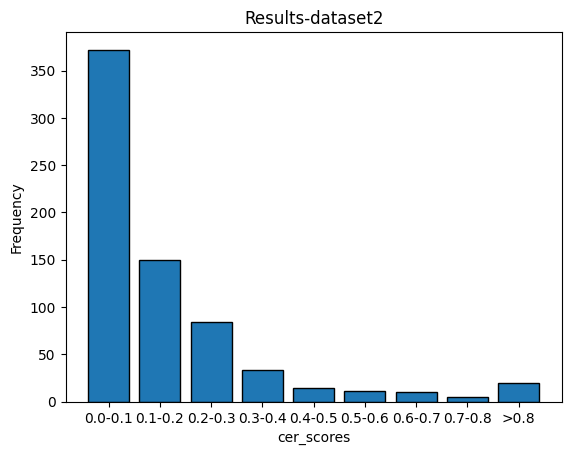

In [22]:
import numpy as np
import matplotlib.pyplot as plt


bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, float('inf')]
bin_counts = np.histogram(cer_data, bins=bins)[0]
bin_labels = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '>0.8']
plt.bar(bin_labels, bin_counts, edgecolor='black')
plt.xlabel('cer_scores')
plt.ylabel('Frequency')
plt.title('Results-dataset2')
plt.show()

In [19]:
cer_data

[0.23076923076923078,
 0.2,
 0.125,
 0.0,
 0.2631578947368421,
 0.0234375,
 0.02,
 0.44,
 0.9529411764705882,
 0.6666666666666666,
 0.18518518518518517,
 0.8222222222222222,
 0.037037037037037035,
 1.2241379310344827,
 0.02631578947368421,
 0.07692307692307693,
 0.5645161290322581,
 0.2781954887218045,
 0.1875,
 0.38095238095238093,
 0.1780821917808219,
 0.20987654320987653,
 0.0782608695652174,
 0.15584415584415584,
 0.013888888888888888,
 0.043478260869565216,
 0.041666666666666664,
 0.21621621621621623,
 0.20634920634920634,
 0.66,
 0.2,
 0.08333333333333333,
 0.02040816326530612,
 0.2727272727272727,
 0.25,
 0.10666666666666667,
 0.0,
 0.4,
 0.2159090909090909,
 0.15384615384615385,
 1.0,
 0.04477611940298507,
 0.4533333333333333,
 0.18181818181818182,
 0.08333333333333333,
 0.038461538461538464,
 0.19298245614035087,
 1.0,
 0.19444444444444445,
 0.17525773195876287,
 0.20218579234972678,
 0.03550295857988166,
 0.10606060606060606,
 0.0,
 0.9859154929577465,
 0.08571428571428572,
 